In [82]:
import sys
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install plotly
#!{sys.executable} -m pip install os
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans



In [83]:
def plot_TSNE(df):
    ax = df.plot.scatter('X','Y')
    ax.set_xlabel('X', fontsize = 15)
    ax.set_ylabel('Y', fontsize = 15)
    ax.set_title('2 component TSNe', fontsize = 20)
    return ax

def TSNE_n_plot(df, PCA_comp, TSNE_comp, perplexity, pvw_h, iter_TSNE = 1000):
    #RECIBE ENTRADAS POR COLUMNAS
    if pvw_h == True:
        cols2drop = ['year','day','hour']
    else:
        cols2drop = ['hidrology','week']
    df = df.drop(columns=cols2drop)
    array_datos = df.to_numpy()
    array_datos = array_datos.transpose()
    array_datos = StandardScaler().fit_transform(array_datos)
    pca = PCA(n_components = PCA_comp)
    ppalComponents = pca.fit_transform(array_datos)
    cols = ['PCA Component ' + str(i) for i in range(1, PCA_comp + 1)]
    pca_df = pd.DataFrame(data = ppalComponents, columns = cols)
    tsne_data = pca_df.to_numpy()
    X_tsne = TSNE(n_components = TSNE_comp, perplexity = perplexity, verbose = 1, n_iter = iter_TSNE).fit_transform(tsne_data)
    df_X_tsne = pd.DataFrame(data = X_tsne, columns = ['X','Y'])
    gens = pd.DataFrame(data = df.columns.values, columns = ['Generadores'])
    df_final = pd.concat([df_X_tsne, gens], axis = 1)
    plot_TSNE(df_final)
    return df_final

In [84]:
def kmeans_plot(df, n_clusters):
    data = df.loc[:,['X','Y']].to_numpy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(data)
    data_labels = ['Cluster ' + str(i) for i in kmeans.labels_]
    output_df = pd.concat([df, pd.DataFrame(data_labels, columns = ['Cluster'])], axis = 1)
    labels = set(data_labels)
    colors = ['b','g','r','c','m','y','k']
    fig = plt.figure(figsize = (8,8))
    ax2 = fig.add_subplot(1,1,1) 
    ax2.set_xlabel('Principal Component 1', fontsize = 15)
    ax2.set_ylabel('Principal Component 2', fontsize = 15)
    ax2.set_title('2 components TSNE', fontsize = 20)
    for idx, label in enumerate(labels):
        indices2Keep = output_df['Cluster'] == label
        ax2.scatter(output_df.loc[indices2Keep,'X'], output_df.loc[indices2Keep,'Y'], c = colors[idx], s = 50)
    return output_df


In [85]:
def show_resulting_profile(df, kmeans):
    result = df.melt(id_vars = ["year","day","hour"], var_name = "Central", value_name = "Perfil")
    result = pd.pivot_table(result, values = "Perfil", index = ["Central","hour"], aggfunc = 'mean').reset_index()
    result = result.merge(kmeans, left_on = "Central", right_on = "Generadores")
    result = result.drop(columns = ["X","Y","Generadores"])
    fig2 = px.line(result, x = "hour", y = "Perfil", color = "Cluster", line_group = "Central", hover_name = "Central")
    fig2.show()


In [86]:
print(os.getcwd())
perfiles = pd.read_csv('profiles.csv', encoding = "utf-8")
gen = pd.read_csv('gen.csv', encoding = "ANSI")
profile_assignation = pd.read_csv('profile_assignation.csv', encoding = 'ANSI')

C:\Users\bmoya\Codigos\Herramientas\Crear clusters


In [87]:
def get_profile(gen, perfiles, profile_assignation, tipo, subsistema):
    gen = gen.merge(profile_assignation, left_on = 'name', right_on = 'name')
    perfiles = perfiles.melt(id_vars = ['year','day','hour'], var_name = "Nombre_perfil", value_name = "Valor_perfil" )
    df = gen[(gen.type == tipo) & (gen.subsystem == subsistema)]
    output = df.merge(perfiles, left_on = "profile", right_on ="Nombre_perfil")
    output = output.loc[:,['name','year','day','hour','Valor_perfil']]
    output = output.pivot_table(index = ['year','day','hour'], columns = 'name', values = 'Valor_perfil').reset_index()
    return output

In [88]:
perfil_PV = get_profile(gen, perfiles, profile_assignation, 'solar', 'SEN')
perfil_W = get_profile(gen, perfiles, profile_assignation, 'wind', 'SEN')
print(perfil_PV)

name   year  day  hour  ADELE_1_FV  AEROPUERTO_FV  ALCALDESA_FV  \
0      2014    1     1    0.773198        0.93368       0.96482   
1      2014    1     2    0.771006        0.93031       0.90955   
2      2014    1     3    0.760160        0.64043       0.79899   
3      2014    1     4    0.725084        0.54942       0.62312   
4      2014    1     5    0.634036        0.26291       0.39196   
...     ...  ...   ...         ...            ...           ...   
52555  2019  365    20    0.463708        0.49212       0.40201   
52556  2019  365    21    0.511096        0.72133       0.63317   
52557  2019  365    22    0.570550        0.88986       0.79899   
52558  2019  365    23    0.588802        0.93368       0.90955   
52559  2019  365    24    0.594452        0.93368       0.95980   

name   ALGARROBO_V_FV  ALHUE_FV  ALICAHUE_FV  ALMEYDA_FV  ...  \
0             0.93368  0.778987      0.99051     0.87075  ...   
1             0.93031  0.776130      0.99170     0.80325  ...   


[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 457 samples in 0.000s...
[t-SNE] Computed neighbors for 457 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 457 / 457
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.559761
[t-SNE] KL divergence after 1000 iterations: 0.184089


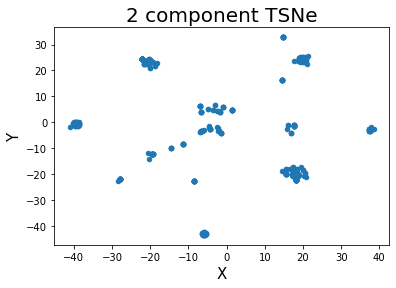

In [89]:
solar = TSNE_n_plot(perfil_PV, PCA_comp = 30, TSNE_comp = 2, perplexity = 12, pvw_h = True)

[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 75 samples in 0.000s...
[t-SNE] Computed neighbors for 75 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 75 / 75
[t-SNE] Mean sigma: 98.984793
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.579865
[t-SNE] KL divergence after 1000 iterations: 0.747730


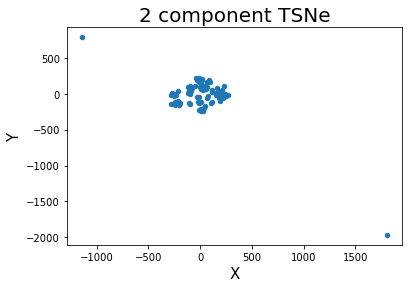

In [90]:
wind = TSNE_n_plot(perfil_W, PCA_comp = 30, TSNE_comp = 2, perplexity = 12, pvw_h = True, iter_TSNE = 1000)

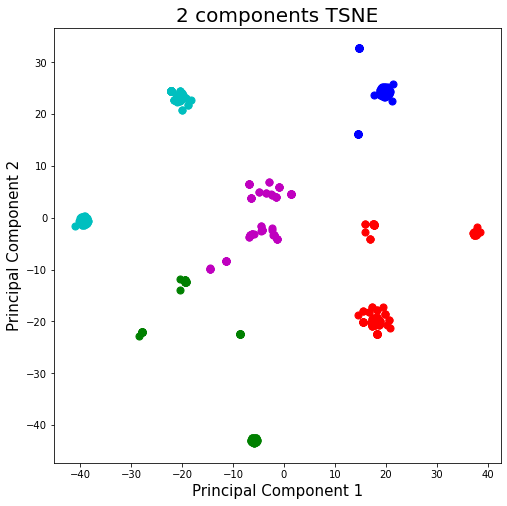

In [91]:
kmeans_solar = kmeans_plot(solar,5)

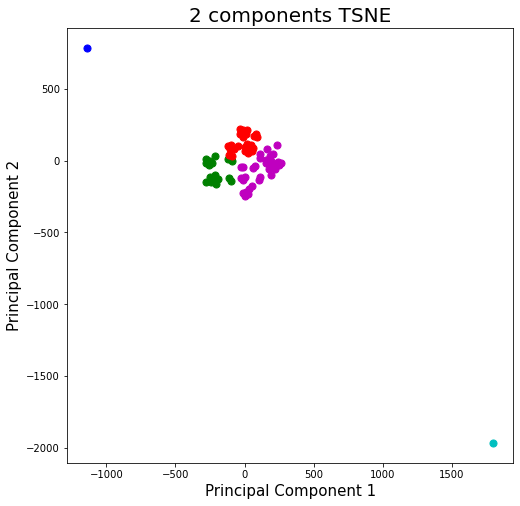

In [92]:
kmeans_wind = kmeans_plot(wind,5)


In [93]:
fig_solar = px.scatter(kmeans_solar, x = "X", y = "Y", color = "Cluster", hover_data = ["Generadores"])
fig_solar

In [94]:
fig_wind = px.scatter(kmeans_wind, x = "X", y = "Y", color = "Cluster", hover_data = ["Generadores"])
fig_wind.show()

In [95]:
show_resulting_profile(perfil_PV,kmeans_solar)

In [96]:
show_resulting_profile(perfil_W,kmeans_wind)

In [97]:
perfil_PV

name,year,day,hour,ADELE_1_FV,AEROPUERTO_FV,ALCALDESA_FV,ALGARROBO_V_FV,ALHUE_FV,ALICAHUE_FV,ALMEYDA_FV,...,VILLA_ALEMANA_FV,VILLA_CRUZ_7_FV,VILLA_CRUZ_FV,VILLA_PRAT_FV,VILLA_PRAT_V_FV,VILLA_SECA_FV,VITUCO_2B_FV,Victoria 13.2 I,WATTS_LONQUEN_FV,Wara_III
0,2014,1,1,0.773198,0.93368,0.96482,0.93368,0.778987,0.99051,0.87075,...,0.773198,0.93368,0.93368,0.96482,0.99282,0.96482,0.96482,0.96482,0.96482,0.96128
1,2014,1,2,0.771006,0.93031,0.90955,0.93031,0.776130,0.99170,0.80325,...,0.771006,0.93031,0.93031,0.90955,0.99043,0.90955,0.90955,0.90955,0.90955,0.96065
2,2014,1,3,0.760160,0.64043,0.79899,0.64043,0.766923,0.98102,0.67613,...,0.760160,0.64043,0.64043,0.79899,0.97488,0.79899,0.79899,0.79899,0.79899,0.95580
3,2014,1,4,0.725084,0.54942,0.62312,0.54942,0.736083,0.94187,0.48938,...,0.725084,0.54942,0.54942,0.62312,0.93182,0.62312,0.62312,0.62312,0.62312,0.92566
4,2014,1,5,0.634036,0.26291,0.39196,0.26291,0.651130,0.53499,0.25538,...,0.634036,0.26291,0.26291,0.39196,0.81699,0.39196,0.39196,0.39196,0.39196,0.83994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,2019,365,20,0.463708,0.49212,0.40201,0.49212,0.112570,0.86002,0.37575,...,0.463708,0.49212,0.49212,0.40201,0.86483,0.40201,0.40201,0.40201,0.40201,0.89353
52556,2019,365,21,0.511096,0.72133,0.63317,0.72133,0.097877,0.93357,0.58725,...,0.511096,0.72133,0.72133,0.63317,0.94019,0.63317,0.63317,0.63317,0.63317,0.91547
52557,2019,365,22,0.570550,0.88986,0.79899,0.88986,0.108560,0.95848,0.74475,...,0.570550,0.88986,0.88986,0.79899,0.96292,0.79899,0.79899,0.79899,0.79899,0.92721
52558,2019,365,23,0.588802,0.93368,0.90955,0.93368,0.125653,0.97628,0.84263,...,0.588802,0.93368,0.93368,0.90955,0.97847,0.90955,0.90955,0.90955,0.90955,0.96709


In [98]:
#perfil_PV2 = pd.pivot_table(gen[perfil_PV.hour == 1], values = "capacity", index = "Cluster", aggfunc = "sum")
#perfil_W2 = pd.pivot_table(gen[perfil_wind.hour == 1], values = "capacity", index = "Cluster", aggfunc = "sum")
#print(perfil_PV2)
#print(perfil_W2)


In [99]:
kmeans_solar

,X,Y,Generadores,Cluster
0,21.168844,22.567493,ADELE_1_FV,Cluster 4
1,-18.192709,22.719751,AEROPUERTO_FV,Cluster 1
2,18.299881,-22.380722,ALCALDESA_FV,Cluster 0
3,-19.973080,20.867817,ALGARROBO_V_FV,Cluster 1
4,37.534130,-2.986349,ALHUE_FV,Cluster 0
...,...,...,...,...
452,15.510561,-18.058712,VILLA_SECA_FV,Cluster 0
453,14.444798,-18.826681,VITUCO_2B_FV,Cluster 0
454,18.299881,-22.380722,Victoria 13.2 I,Cluster 0
455,18.299881,-22.380722,WATTS_LONQUEN_FV,Cluster 0


In [100]:
gen2 = gen.loc[:,['name','capacity']]
kmeans_solar = kmeans_solar.merge(gen2, left_on= 'Generadores' , right_on = 'name').drop(columns = ['X','Y','Generadores'])
kmeans_wind = kmeans_wind.merge(gen2, left_on= 'Generadores' , right_on = 'name').drop(columns = ['X','Y','Generadores'])

In [101]:
kmeans_solar.to_csv('cluster_solar.csv', index = False)
kmeans_wind.to_csv('cluster_wind.csv', index = False)
